<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/07_Granger_VAR_Forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Granger Causality + VAR Forecasting (R / Colab)

본 노트북은 **그랜저 인과관계(Granger causality)**를 사용해 두 자산 간 예측 가능성을 점검하고,
**VAR(Vector AutoRegression)** 모형으로 4가지 백테스트/운영 방식(Full-sample, Fixed-origin, Rolling, Expanding)
을 구현합니다. (Colab R 커널에서 실행 가능)


In [1]:
## --- 환경설정: 그래프 크기/해상도, 경고 억제 ---
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)
options(warn = -1)

## --- 패키지 설치 및 로딩 ---
need <- c('quantmod','vars','lmtest','urca','tseries','ggplot2','dplyr','tidyr','tibble','lubridate')
installed <- rownames(installed.packages())
for (p in need) {
  if (!(p %in% installed)) {
    install.packages(p, repos = 'https://cloud.r-project.org')
  }
  suppressPackageStartupMessages(library(p, character.only = TRUE))
}
set.seed(42)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘strucchange’, ‘urca’, ‘lmtest’, ‘sandwich’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘quadprog’




In [2]:
## ===========================
## 1) 데이터 로드 (TSLA, SPY) & 로그수익률(%)
## ===========================
symbol_y <- 'TSLA'  # 예측 타깃
symbol_x <- 'SPY'   # 외생적 예측자
start_date <- '2022-01-01'
end_date   <- '2024-01-01'

suppressWarnings(suppressMessages(
  getSymbols(Symbols = c(symbol_y, symbol_x), src = 'yahoo', from = start_date, to = end_date, auto.assign = TRUE)
))

# Adjusted 존재 시 우선, 없으면 Close 사용
get_price_col <- function(sym_xts) {
  cn <- colnames(sym_xts)
  has_adj <- any(grepl('Adjusted$', cn))
  has_cls <- any(grepl('Close$', cn))
  if (has_adj) return(Ad(sym_xts))
  if (has_cls) return(Cl(sym_xts))
  stop('No Adjusted/Close column found for symbol')
}

px_y <- get_price_col(get(symbol_y))
px_x <- get_price_col(get(symbol_x))
px   <- na.omit(merge(px_y, px_x, join = 'inner'))
colnames(px) <- c(paste0('Close_', symbol_y), paste0('Close_', symbol_x))

# 로그수익률(%)
ret <- na.omit(diff(log(px))) * 100
colnames(ret) <- c(paste0('ret_', symbol_y), paste0('ret_', symbol_x))
dates <- index(ret)
cat(sprintf('%s/%s: %d returns | %s ~ %s\n', symbol_y, symbol_x, NROW(ret), as.Date(dates[1]), as.Date(dates[NROW(ret)])))

# 타깃 가격(나중에 수익률→가격 복원)
price_y <- px[, 1]


[1] "TSLA" "SPY"

TSLA/SPY: 500 returns | 2022-01-04 ~ 2023-12-29


In [3]:
## ===========================
## 2) 정상성 간단 점검 & 학습/테스트 분할
## ===========================
# adf.test는 시계열 길이에 민감 – 여기선 로그수익률을 쓰므로 보통 정상성 가정 OK
adf_y <- tryCatch(tseries::adf.test(as.numeric(ret[,1])), error = function(e) NULL)
adf_x <- tryCatch(tseries::adf.test(as.numeric(ret[,2])), error = function(e) NULL)
if (!is.null(adf_y)) cat(sprintf('ADF p (target)   : %.4f\n', adf_y$p.value))
if (!is.null(adf_x)) cat(sprintf('ADF p (predictor): %.4f\n', adf_x$p.value))

split_idx <- floor(NROW(ret) * 0.8)
ret_train <- ret[1:split_idx, ]
ret_test  <- ret[(split_idx+1):NROW(ret), ]

price_train_y <- price_y[1:split_idx]
price_test_y  <- price_y[(split_idx+1):NROW(price_y)]
dates_train <- index(ret_train)
dates_test  <- index(ret_test)
cat(sprintf('train=%d, test=%d\n', NROW(ret_train), NROW(ret_test)))


ADF p (target)   : 0.0100
ADF p (predictor): 0.0100
train=400, test=100


In [4]:
## ===========================
## 3) Lag 선택(AIC/BIC) & 그랜저 인과관계
## ===========================
sel <- VARselect(ret_train, lag.max = 10, type = 'const')
print(sel$selection)
lag0 <- sel$selection[['AIC(n)']]
if (is.na(lag0) || lag0 < 1) lag0 <- 1
cat(sprintf('Chosen lag (AIC): %d\n', lag0))

fit_var_train <- VAR(ret_train, p = lag0, type = 'const')

# H0: cause 변수가 target을 그랜저 원인으로 설명하지 않는다
gc_x_to_y <- vars::causality(fit_var_train, cause = paste0('ret_', symbol_x))
gc_y_to_x <- vars::causality(fit_var_train, cause = paste0('ret_', symbol_y))
cat('\n[Granger causality on TRAIN]\n')
print(gc_x_to_y$Granger)
print(gc_y_to_x$Granger)


AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      1      1      2 
Chosen lag (AIC): 2

[Granger causality on TRAIN]

	Granger causality H0: ret_SPY do not Granger-cause ret_TSLA

data:  VAR object fit_var_train
F-Test = 1.099, df1 = 2, df2 = 786, p-value = 0.3337


	Granger causality H0: ret_TSLA do not Granger-cause ret_SPY

data:  VAR object fit_var_train
F-Test = 1.7909, df1 = 2, df2 = 786, p-value = 0.1675



In [5]:
## ===========================
## 4) 유틸 함수 (지표, 가격 복원 등)
## ===========================
rmse <- function(a, b) sqrt(mean((a - b)^2))
mae  <- function(a, b) mean(abs(a - b))
r2   <- function(a, b) 1 - sum((a - b)^2)/sum((a - mean(a))^2)

to_price_path <- function(p0, returns_pct) {
  p <- numeric(length(returns_pct))
  prev <- as.numeric(p0)
  for (i in seq_along(returns_pct)) {
    prev <- prev * exp(as.numeric(returns_pct[i]) / 100)
    p[i] <- prev
  }
  p
}

safe_var_fit <- function(y_df, p_lag) {
  out <- tryCatch(VAR(y_df, p = p_lag, type = 'const'), error = function(e) NULL)
  out
}


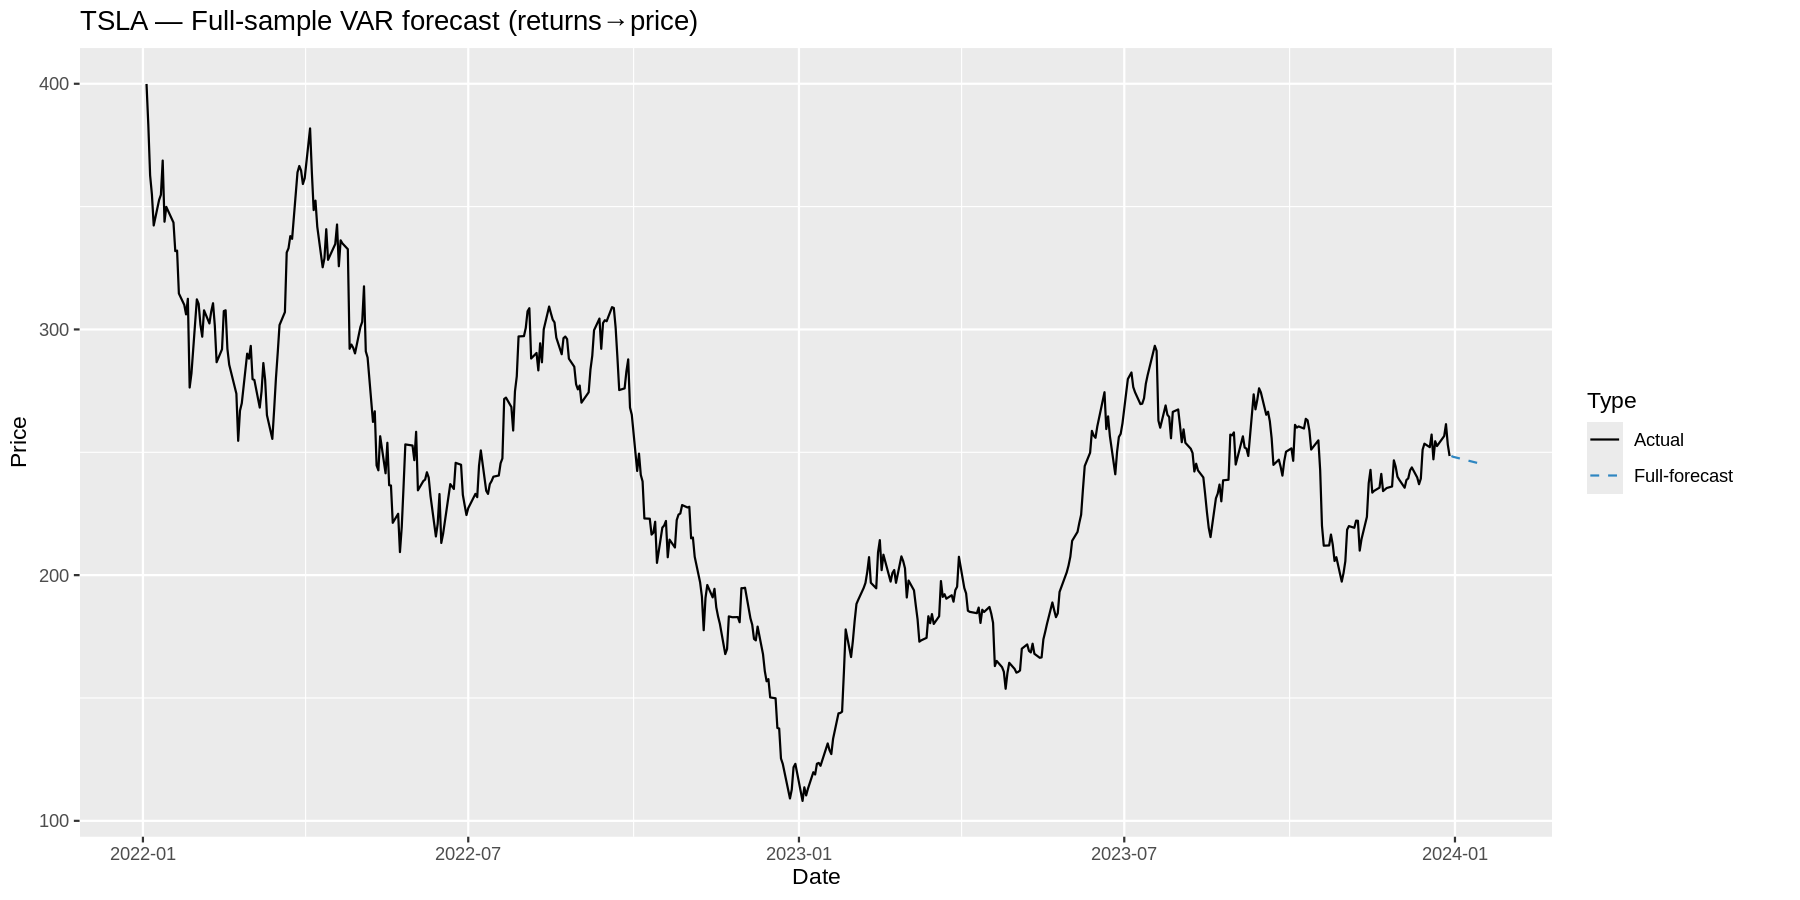

In [6]:
## ===========================
## 5) Full-sample (final fit) — 전체 표본으로 적합 → 미래 h 예측 (평가용 X)
## ===========================
h <- 20
fit_full <- safe_var_fit(ret, lag0)
pred_full <- if (!is.null(fit_full)) predict(fit_full, n.ahead = h) else NULL
ret_fcst_full_y <- if (!is.null(pred_full)) as.numeric(pred_full$fcst[[paste0('ret_', symbol_y)]][,'fcst']) else rep(0, h)

p0_last <- as.numeric(last(price_y))
px_full <- to_price_path(p0_last, ret_fcst_full_y)
future_dates <- seq(from = as.Date(last(index(price_y))) + 1, by = 'day', length.out = h)

plot_df <- tibble(Date = c(as.Date(index(price_y)), future_dates),
                  Price = c(as.numeric(price_y), px_full),
                  Type  = c(rep('Actual', length(price_y)), rep('Full-forecast', length(px_full))))

ggplot(plot_df, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c('Actual'='black','Full-forecast'='#2E86C1')) +
  scale_linetype_manual(values = c('Actual'='solid','Full-forecast'='dashed')) +
  labs(title = sprintf('%s — Full-sample VAR forecast (returns→price)', symbol_y), x='Date', y='Price')


[Fixed-origin] RMSE=17.8076 | MAE=14.7665 | R2=-0.0445


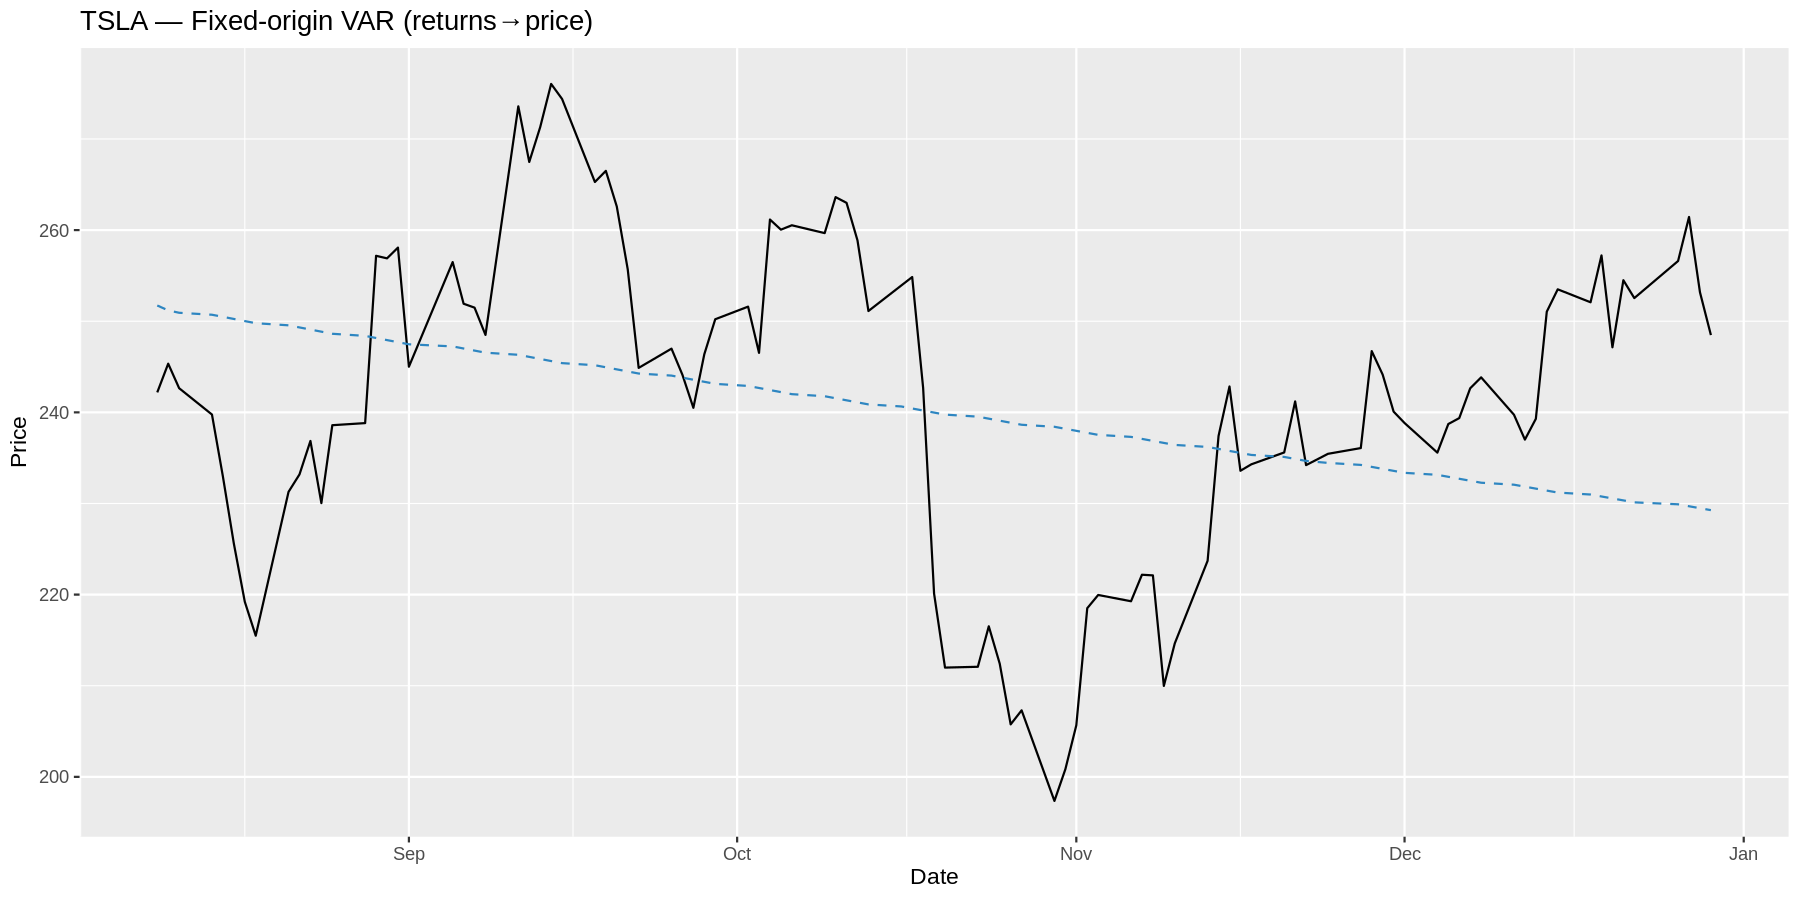

In [8]:
## ===========================
## 6) Fixed-origin — 학습(80%)으로 한 번 적합 → 테스트 전구간 다단계 예측
## ===========================
fit_fix <- safe_var_fit(ret_train, lag0)
pred_fix <- if (!is.null(fit_fix)) predict(fit_fix, n.ahead = NROW(ret_test)) else NULL
ret_pred_fix_y <- if (!is.null(pred_fix)) as.numeric(pred_fix$fcst[[paste0('ret_', symbol_y)]][,'fcst']) else rep(0, NROW(ret_test))
p0_test <- as.numeric(last(price_train_y))
pred_fix_price <- to_price_path(p0_test, ret_pred_fix_y)

rmse_fix <- rmse(as.numeric(price_test_y), pred_fix_price)
mae_fix  <- mae (as.numeric(price_test_y), pred_fix_price)
r2_fix   <- r2  (as.numeric(price_test_y), pred_fix_price)
cat(sprintf('[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_fix, mae_fix, r2_fix))

df_fx <- tibble(Date = as.Date(dates_test), Actual = as.numeric(price_test_y)[-1], Pred = pred_fix_price)
ggplot(df_fx, aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred),    color = '#2E86C1', linetype = 'dashed') +
  labs(title = sprintf('%s — Fixed-origin VAR (returns→price)', symbol_y), x='Date', y='Price')

[Rolling window] RMSE=44.9250 | MAE=36.0592 | R2=-5.6476


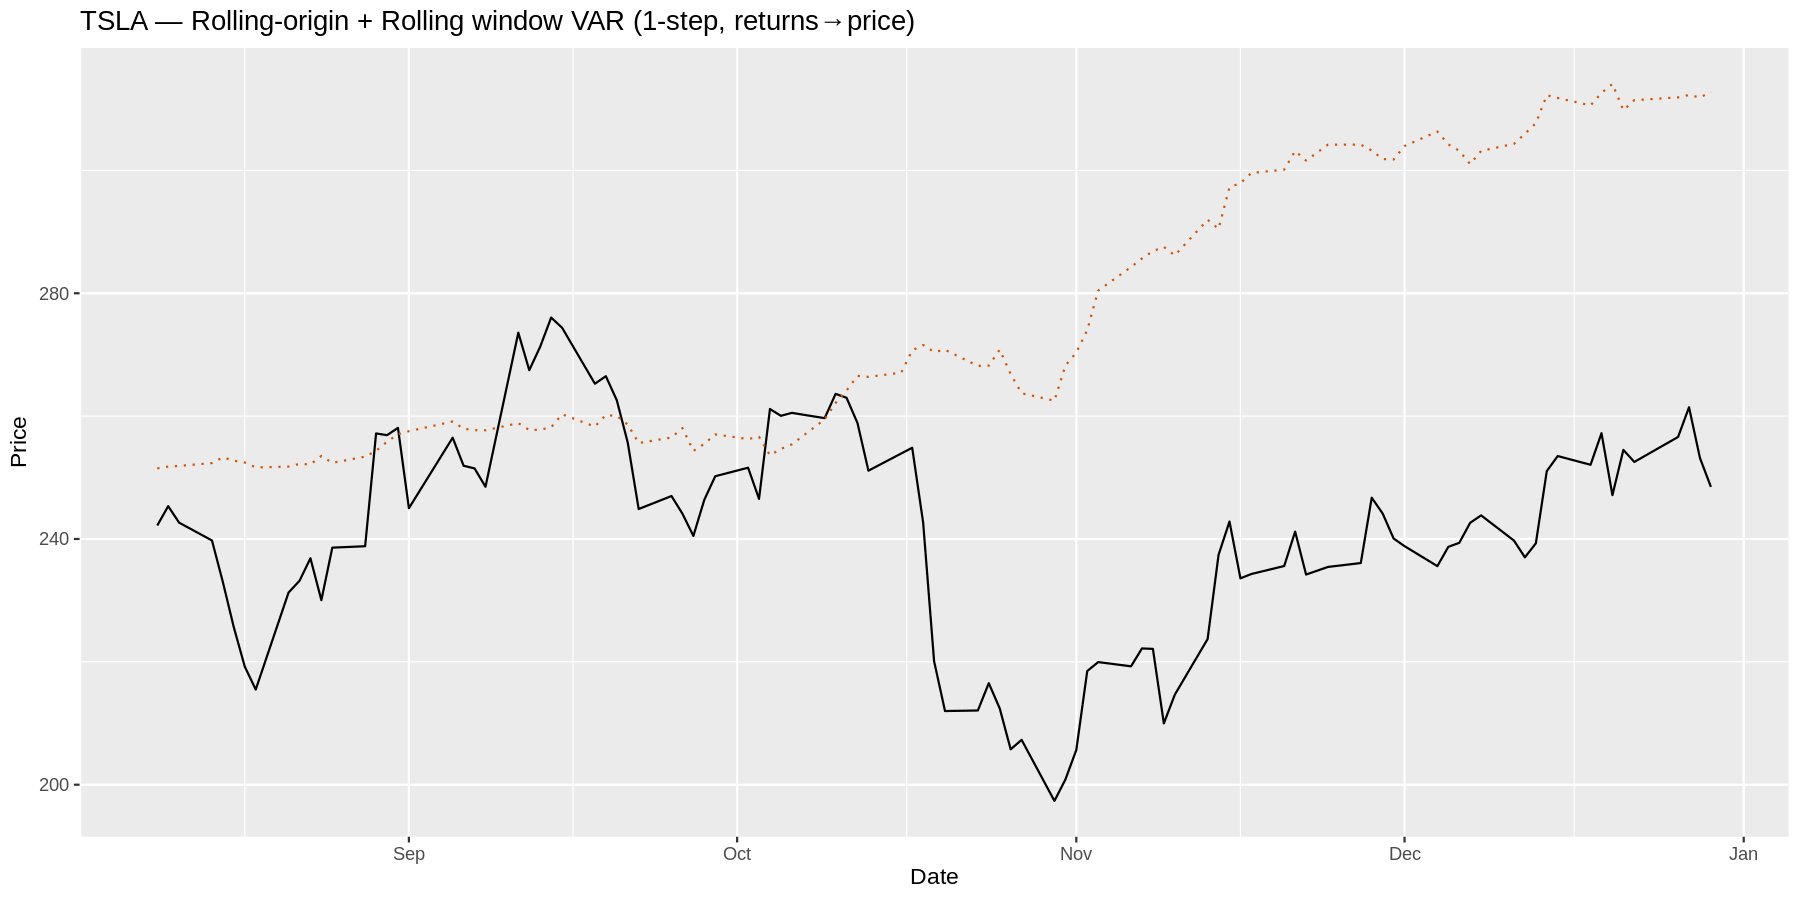

In [10]:
## ===========================
## 7) Rolling-origin + Rolling window — 고정 길이 W, 1-step 예측
## ===========================
W <- 120
stride <- 10  # lag 재선택 주기 (0이면 고정)
pred_roll_y <- rep(NA_real_, NROW(ret_test))
hist <- ret_train
lag_curr <- lag0

for (i in seq_len(NROW(ret_test))) {
  y_win <- if (NROW(hist) > W) tail(hist, W) else hist
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    sel_w <- VARselect(y_win, lag.max = 5, type = 'const')
    lag_new <- sel_w$selection[['AIC(n)']]
    if (!is.na(lag_new) && lag_new >= 1) lag_curr <- lag_new
  }
  fit_w <- safe_var_fit(y_win, lag_curr)
  if (is.null(fit_w)) {
    pred_roll_y[i] <- 0
  } else {
    fc1 <- predict(fit_w, n.ahead = 1)
    pred_roll_y[i] <- as.numeric(fc1$fcst[[paste0('ret_', symbol_y)]][1,'fcst'])
  }
  # 워크-포워드
  hist <- rbind(hist, ret_test[i,])
}

pred_roll_price <- to_price_path(as.numeric(last(price_train_y)), pred_roll_y)
rmse_r <- rmse(as.numeric(price_test_y), pred_roll_price)
mae_r  <- mae (as.numeric(price_test_y), pred_roll_price)
r2_r   <- r2  (as.numeric(price_test_y), pred_roll_price)
cat(sprintf('[Rolling window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_r, mae_r, r2_r))

df_rl <- tibble(Date = as.Date(dates_test), Actual = as.numeric(price_test_y)[-1], Pred = pred_roll_price)
ggplot(df_rl, aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred),    color = '#D35400', linetype = 'dotted') +
  labs(title = sprintf('%s — Rolling-origin + Rolling window VAR (1-step, returns→price)', symbol_y), x='Date', y='Price')

[Expanding window] RMSE=16.7016 | MAE=14.1540 | R2=0.0812


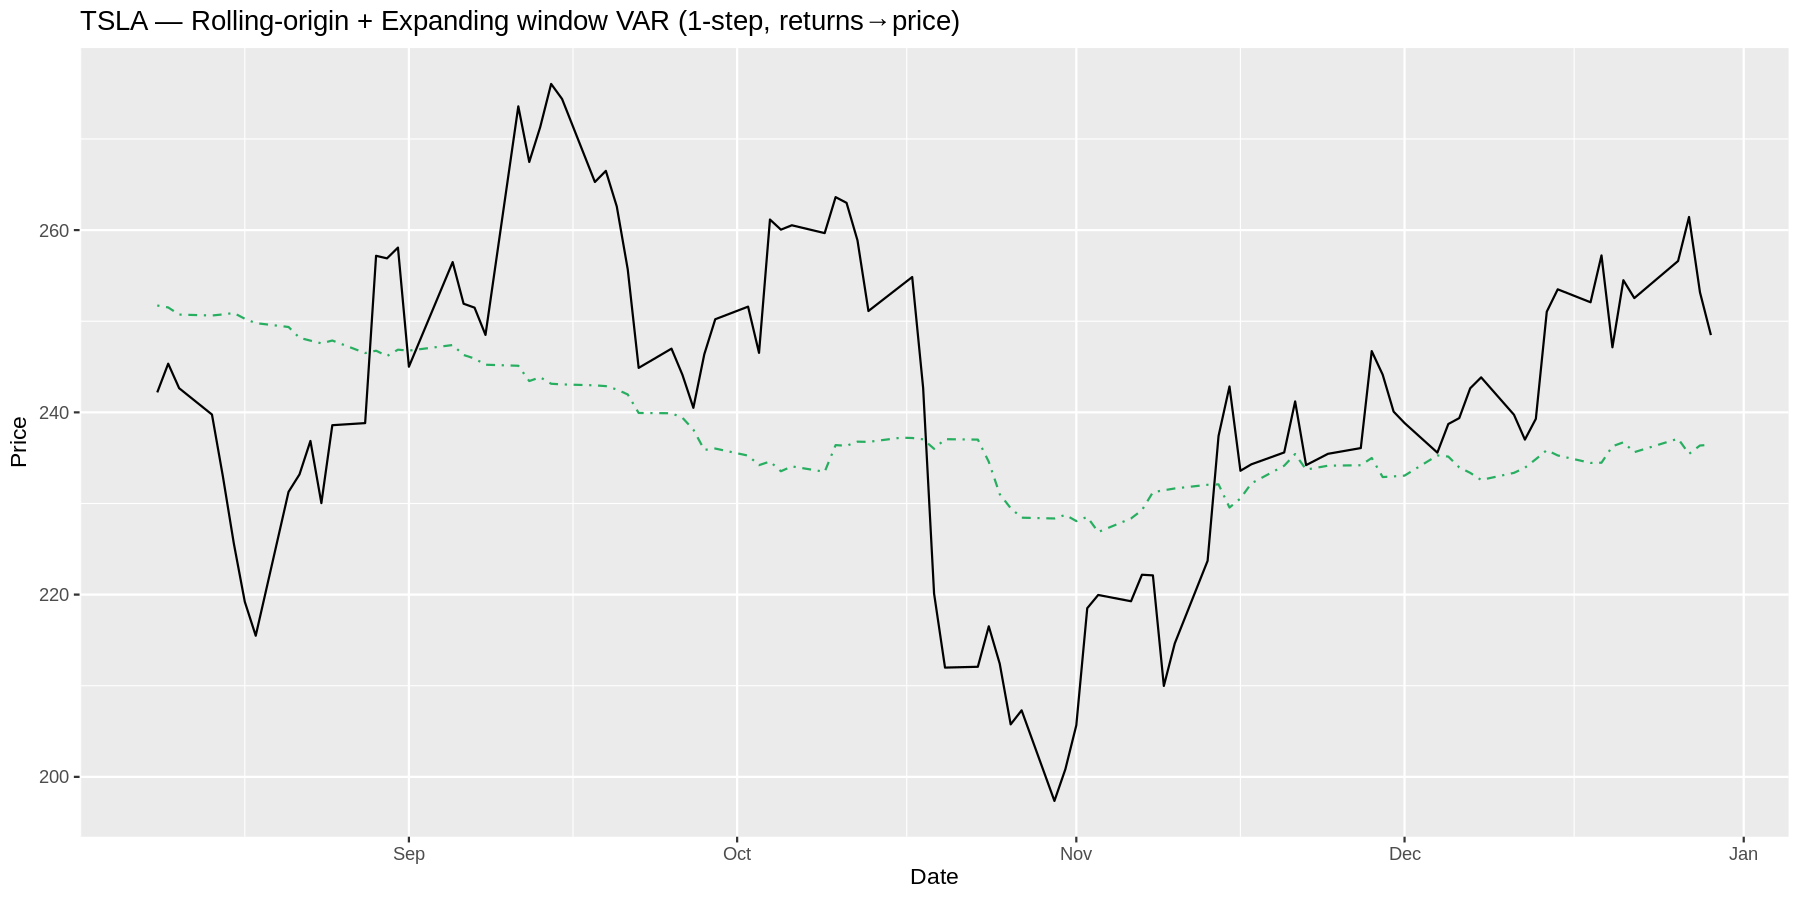

In [12]:
## ===========================
## 8) Rolling-origin + Expanding window — 누적 창, 1-step 예측
## ===========================
pred_exp_y <- rep(NA_real_, NROW(ret_test))
hist <- ret_train
lag_curr <- lag0

for (i in seq_len(NROW(ret_test))) {
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    sel_e <- VARselect(hist, lag.max = 5, type = 'const')
    lag_new <- sel_e$selection[['AIC(n)']]
    if (!is.na(lag_new) && lag_new >= 1) lag_curr <- lag_new
  }
  fit_e <- safe_var_fit(hist, lag_curr)
  if (is.null(fit_e)) {
    pred_exp_y[i] <- 0
  } else {
    fc1 <- predict(fit_e, n.ahead = 1)
    pred_exp_y[i] <- as.numeric(fc1$fcst[[paste0('ret_', symbol_y)]][1,'fcst'])
  }
  hist <- rbind(hist, ret_test[i,])
}

pred_exp_price <- to_price_path(as.numeric(last(price_train_y)), pred_exp_y)
rmse_e <- rmse(as.numeric(price_test_y), pred_exp_price)
mae_e  <- mae (as.numeric(price_test_y), pred_exp_price)
r2_e   <- r2  (as.numeric(price_test_y), pred_exp_price)
cat(sprintf('[Expanding window] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_e, mae_e, r2_e))

df_ex <- tibble(Date = as.Date(dates_test), Actual = as.numeric(price_test_y)[-1], Pred = pred_exp_price)
ggplot(df_ex, aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred),    color = '#27AE60', linetype = 'dotdash') +
  labs(title = sprintf('%s — Rolling-origin + Expanding window VAR (1-step, returns→price)', symbol_y), x='Date', y='Price')

# A tibble: 3 × 4
  Method            RMSE   MAE      R2
  <chr>            <dbl> <dbl>   <dbl>
1 Expanding window  16.7  14.2  0.0812
2 Fixed-origin      17.8  14.8 -0.0445
3 Rolling window    44.9  36.1 -5.65  


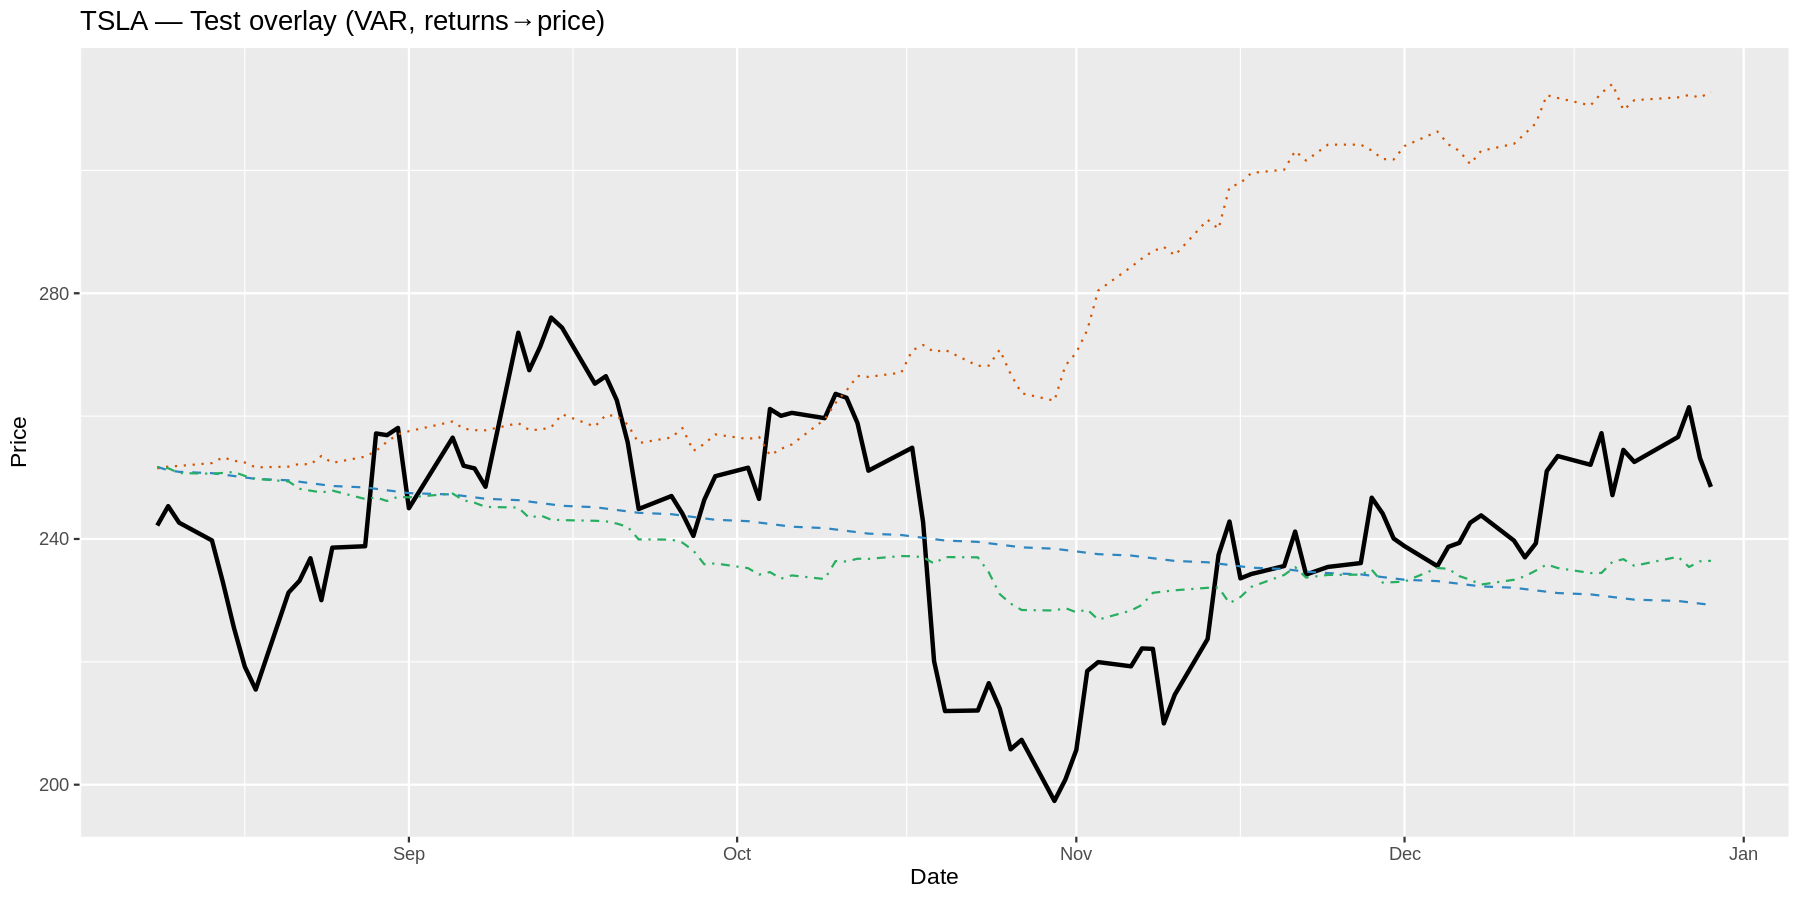

In [14]:
## ===========================
## 9) 요약 표 & 오버레이
## ===========================
summary_tbl <- tibble::tibble(
  Method = c('Fixed-origin', 'Rolling window', 'Expanding window'),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)
print(summary_tbl)

ggplot() +
  geom_line(data = tibble(Date = as.Date(dates_test), Price = as.numeric(price_test_y)[-1]),
            aes(Date, Price), color = 'black', linewidth = 1) +
  geom_line(data = tibble(Date = as.Date(dates_test), Price = pred_fix_price),
            aes(Date, Price), linetype = 'dashed', color = '#2E86C1') +
  geom_line(data = tibble(Date = as.Date(dates_test), Price = pred_roll_price),
            aes(Date, Price), linetype = 'dotted',  color = '#D35400') +
  geom_line(data = tibble(Date = as.Date(dates_test), Price = pred_exp_price),
            aes(Date, Price), linetype = 'dotdash', color = '#27AE60') +
  labs(title = sprintf('%s — Test overlay (VAR, returns→price)', symbol_y), x='Date', y='Price')

### 메모
- **Granger causality**는 인과가 아니라 **예측 가능성**을 의미합니다. 여기서는 VAR 모형의 타당성을 뒷받침/점검하는 용도로 사용했습니다.
- **Fixed-origin**은 빠르고 간단하지만 드리프트에 둔감할 수 있습니다.
- **Rolling window**는 최근성에 민감, **Expanding window**는 안정성/데이터 축적에 유리합니다.
- 필요 시 `lag.max`, `W`, `stride` 등을 조정하세요.
